# Predicting MLB Salaries


## I.  Introduction
This project builds a model using XGBoost to predict Major League Baseball (MLB) player salaries.  Two separate models are built for pitchers and field players.

Being able to predict MLB player salaries would help in determining a player's value as well as provide inforamation about what factors drive value creation.  This would help in salary negotions, determing team budgets, and finding out which players may be under- or over-valued.

All data for this project come from the Lahman Baseball Database.

## II. Data

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import explained_variance_score

import statsmodels.api as sm

from statsmodels.graphics.gofplots import ProbPlot

plt.style.use('seaborn') # pretty matplotlib plots

plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

/Users/jeff/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Import the batting, pitching and salary data. The data comes from the Lahman Baseball Database. http://www.seanlahman.com/baseball-database.html

In [2]:
batting = pd.read_csv('Batting.csv')
pitching = pd.read_csv('Pitching.csv')
salaries = pd.read_csv('Salaries.csv')


### Batting Data

In [3]:
batting.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,...,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,...,13.0,8.0,1.0,4,0.0,NaN,NaN,NaN,NaN,NaN
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,...,19.0,3.0,1.0,2,5.0,NaN,NaN,NaN,NaN,NaN
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,...,27.0,1.0,1.0,0,2.0,NaN,NaN,NaN,NaN,NaN
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,...,16.0,6.0,2.0,2,1.0,NaN,NaN,NaN,NaN,NaN


In [4]:
batting.describe()

,yearID,stint,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
count,102816.000000,102816.000000,102816.000000,102816.000000,102816.000000,102816.000000,102816.000000,102816.000000,102816.000000,102392.000000,101516.000000,79360.000000,102816.000000,94978.000000,66251.000000,100006.000000,96478.000000,66782.000000,76706.000000
mean,1964.262313,1.077838,51.343439,141.905511,18.815544,37.139930,6.289167,1.293252,2.813599,17.003975,2.976821,1.226008,13.067207,20.529712,1.105870,1.056057,2.299540,1.054101,2.981018
std,38.856297,0.284366,47.121658,184.654492,28.242983,52.603757,9.662468,2.645770,6.304919,26.352011,7.717174,2.747377,20.746460,28.328542,2.780187,2.276251,4.241095,1.961732,4.735153
min,1871.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1934.000000,1.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1973.000000,1.000000,34.000000,49.000000,4.000000,9.000000,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,3.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1998.000000,1.000000,80.000000,231.000000,27.000000,58.000000,9.000000,1.000000,2.000000,24.000000,2.000000,1.000000,18.000000,29.000000,1.000000,1.000000,3.000000,1.000000,4.000000
max,2016.000000,5.000000,165.000000,716.000000,192.000000,262.000000,67.000000,36.000000,73.000000,191.000000,138.000000,42.000000,232.000000,223.000000,120.000000,51.000000,67.000000,19.000000,36.000000


Below is a description of the variables in the batting data frame. It is a data frame with 102816 observations on 22 variables.
- playerID - Player ID code
- yearID - Year
- stint - player’s stint (order of appearances within a season)
- teamID - Team; a factor
- lgID - League; a factor with levels AA AL FL NL PL UA
- G - Games: number of games in which a player played
- AB - At Bats
- R - Runs
- H - Hits: times reached base because of a batted, fair ball without error by the defense
- 2B - Doubles: hits on which the batter reached second base safely
- 3B - Triples: hits on which the batter reached third base safely
- HR - Homeruns
- RBI - Runs Batted In
- SB - Stolen Bases
- CS - Caught Stealing
- BB - Base on Balls
- SO - Strikeouts
- IBB - Intentional walks
- HBP - Hit by pitch
- SH - Sacrifice hits
- SF - Sacrifice flies
- GIDP - Grounded into double plays

### Pitching Data

In [5]:
pitching.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,...,NaN,NaN,NaN,0,NaN,NaN,42,NaN,NaN,NaN
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,...,NaN,NaN,NaN,0,NaN,NaN,292,NaN,NaN,NaN
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,...,NaN,NaN,NaN,0,NaN,NaN,9,NaN,NaN,NaN
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,...,NaN,NaN,NaN,0,NaN,NaN,257,NaN,NaN,NaN
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,...,NaN,NaN,NaN,0,NaN,NaN,21,NaN,NaN,NaN


In [6]:
pitching.describe()

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
count,44963.000000,44963.000000,44963.000000,44963.000000,44963.000000,44963.000000,44963.000000,44963.000000,44963.000000,44963.000000,...,30388.000000,44830.000000,44405.000000,44963.000000,44724.000000,44830.000000,44963.000000,12063.000000,12063.000000,12061.000000
mean,1968.670062,1.079643,4.715744,4.715722,23.681761,9.485488,3.151035,0.448591,1.504793,253.872139,...,2.411379,2.528575,2.266096,0.301604,343.312181,6.345260,43.021773,2.141922,1.878388,5.322610
std,37.569499,0.284834,5.813410,4.988846,18.493488,12.283920,7.081844,1.109742,4.991518,257.330446,...,2.772648,3.425706,2.998881,0.755523,348.758261,9.993949,43.245812,2.710191,2.121352,5.990178
min,1871.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1941.000000,1.000000,0.000000,1.000000,7.000000,0.000000,0.000000,0.000000,0.000000,49.000000,...,0.000000,0.000000,0.000000,0.000000,64.000000,0.000000,11.000000,0.000000,0.000000,1.000000
50%,1978.000000,1.000000,2.000000,3.000000,21.000000,3.000000,0.000000,0.000000,0.000000,167.000000,...,2.000000,1.000000,1.000000,0.000000,227.000000,3.000000,28.000000,1.000000,1.000000,3.000000
75%,2001.000000,1.000000,7.000000,8.000000,35.000000,17.000000,3.000000,0.000000,1.000000,393.000000,...,4.000000,4.000000,3.000000,0.000000,535.000000,8.000000,67.000000,3.000000,3.000000,8.000000
max,2016.000000,4.000000,59.000000,48.000000,106.000000,75.000000,75.000000,16.000000,62.000000,2040.000000,...,23.000000,63.000000,41.000000,16.000000,2906.000000,84.000000,519.000000,21.000000,14.000000,40.000000




Pitching: A data frame with 44963 observations on the following 30 variables.
- playerID - Player ID code
- yearID - Year
- stint - player’s stint (order of appearances within a season)
- teamID - Team; a factor
- lgID - League; a factor with levels AA AL FL NL PL UA
- W - Wins
- L - Losses
- G - Games
- GS - Games Started
- CG - Complete Games
- SHO - Shutouts
- SV - Saves
- IPouts - Outs Pitched (innings pitched x 3)
- H - Hits
- ER - Earned Runs
- HR - Homeruns
- BB - Walks
- SO - Strikeouts
- BAOpp - Opponent’s Batting Average
- ERA - Earned Run Average
- IBB - Intentional Walks
- WP - Wild Pitches
- HBP - Batters Hit By Pitch
- BK - Balks
- BFP - Batters faced by Pitcher
- GF - Games Finished
- R - Runs Allowed
- SH - Sacrifices by opposing batters
- SF - Sacrifice flies by opposing batters
- GIDP - Grounded into double plays by opposing batter

### Salary Data

In [7]:
salaries.head()

,yearID,teamID,lgID,playerID,salary
0,1985,ATL,NL,barkele01,870000
1,1985,ATL,NL,bedrost01,550000
2,1985,ATL,NL,benedbr01,545000
3,1985,ATL,NL,campri01,633333
4,1985,ATL,NL,ceronri01,625000


In [8]:
salaries.describe()

,yearID,salary
count,26428.000000,2.642800e+04
mean,2000.878727,2.085634e+06
std,8.909314,3.455348e+06
min,1985.000000,0.000000e+00
25%,1994.000000,2.947020e+05
50%,2001.000000,5.500000e+05
75%,2009.000000,2.350000e+06
max,2016.000000,3.300000e+07


## III. Data Wrangling

There are pitchers in the batting data set which need to be removed.  The pitchers have very limited batting stats, so it looks like the pitchers earn a salary with out being productive at the plate.   Instead, their salary is tied to pitcher productivity and not batting productivity.  A separate model will be developed for pitchers with their corresponding productivity stats.

In [9]:
pitchers = np.unique(pitching.playerID)
pitchers = pd.DataFrame(pitchers)
pitchers.columns = ['playerID']

all_df =pd.merge(batting, pitchers, how='outer', on='playerID', indicator=True)
batting_only = all_df[all_df['_merge'] == 'left_only']
batting_only.describe()

,yearID,stint,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
count,53340.000000,53340.000000,53340.000000,53340.000000,53340.000000,53340.000000,53340.000000,53340.000000,53340.000000,53098.000000,52677.000000,40660.000000,53340.000000,49162.000000,32990.000000,51791.000000,50173.000000,33296.000000,39049.000000
mean,1962.322928,1.074634,70.698856,228.917548,30.815186,61.064267,10.479715,2.059168,4.934064,28.158104,4.866469,2.203443,21.921597,32.496847,2.081358,1.775173,3.039902,1.938521,5.302133
std,38.227846,0.279936,52.078948,199.304174,31.165314,57.548072,10.864152,3.056457,7.799529,29.674853,9.171428,3.375429,23.595442,32.566583,3.551851,2.759967,5.033805,2.341149,5.413045
min,1871.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1932.000000,1.000000,20.000000,43.000000,4.000000,9.000000,1.000000,0.000000,0.000000,4.000000,0.000000,0.000000,3.000000,7.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1970.000000,1.000000,65.000000,174.000000,20.000000,43.000000,7.000000,1.000000,1.000000,18.000000,1.000000,1.000000,14.000000,22.000000,1.000000,1.000000,1.000000,1.000000,4.000000
75%,1995.000000,1.000000,119.000000,402.000000,51.000000,106.000000,17.000000,3.000000,6.000000,45.000000,5.000000,3.000000,34.000000,49.000000,3.000000,2.000000,4.000000,3.000000,8.000000
max,2016.000000,5.000000,165.000000,716.000000,192.000000,254.000000,67.000000,36.000000,73.000000,191.000000,138.000000,42.000000,232.000000,223.000000,120.000000,51.000000,67.000000,19.000000,36.000000


Creating a experience variable which represents years in the league.  This will also serve as a timetrend for each player as well. 

In [10]:
batting_only['EXP'] = batting_only.groupby('playerID').cumcount()+1



batting_only.sort_values(by=['playerID', 'yearID']).head()


/Users/jeff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,CS,BB,SO,IBB,HBP,SH,SF,GIDP,_merge,EXP
39907,aaronha01,1954,1,ML1,NL,122,468,58,131,27,...,2.0,28,39.0,NaN,3.0,6.0,4.0,13.0,left_only,1
39908,aaronha01,1955,1,ML1,NL,153,602,105,189,37,...,1.0,49,61.0,5.0,3.0,7.0,4.0,20.0,left_only,2
39909,aaronha01,1956,1,ML1,NL,153,609,106,200,34,...,4.0,37,54.0,6.0,2.0,5.0,7.0,21.0,left_only,3
39910,aaronha01,1957,1,ML1,NL,151,615,118,198,27,...,1.0,57,58.0,15.0,0.0,0.0,3.0,13.0,left_only,4
39911,aaronha01,1958,1,ML1,NL,153,601,109,196,34,...,1.0,59,49.0,16.0,1.0,0.0,3.0,21.0,left_only,5


Let's also create a dummy variable which represents whether a player was an all-star or not. It will be interesting to compare the salary distributions across all-star and non-all-star players.  It will be also interesting to compare the differences of salary growth among these two groups.  Let's first inspect the all-star data.

In [11]:
all_star_full = pd.read_csv('AllStarFull.csv')
all_star_full.head()

,playerID,yearID,gameNum,gameID,teamID,lgID,GP,startingPos
0,gomezle01,1933,0,ALS193307060,NYA,AL,1.0,1.0
1,ferreri01,1933,0,ALS193307060,BOS,AL,1.0,2.0
2,gehrilo01,1933,0,ALS193307060,NYA,AL,1.0,3.0
3,gehrich01,1933,0,ALS193307060,DET,AL,1.0,4.0
4,dykesji01,1933,0,ALS193307060,CHA,AL,1.0,5.0


Let's add a indicator variable that represents all-start status.

In [12]:
all_star_full['allStar'] = 1
all_star = all_star_full[['playerID', 'yearID', 'allStar']]
batting_only_allStar = pd.merge(batting_only, all_star, how='left', on=['playerID','yearID'])
batting_only_allStar.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,BB,SO,IBB,HBP,SH,SF,GIDP,_merge,EXP,allStar
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,...,0,0.0,NaN,NaN,NaN,NaN,NaN,left_only,1,NaN
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,...,4,0.0,NaN,NaN,NaN,NaN,NaN,left_only,1,NaN
2,addybo01,1873,1,PH2,NaN,10,51,12,16,1,...,2,0.0,NaN,NaN,NaN,NaN,NaN,left_only,2,NaN
3,addybo01,1873,2,BS1,NaN,31,152,37,54,5,...,1,0.0,NaN,NaN,NaN,NaN,NaN,left_only,3,NaN
4,addybo01,1874,1,HR1,NaN,50,213,25,51,9,...,1,0.0,NaN,NaN,NaN,NaN,NaN,left_only,4,NaN


In [13]:
pitching['EXP'] = pitching.groupby('playerID').cumcount()+1
pitching.sort_values(by=['playerID', 'yearID']).head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,EXP
35564,aardsda01,2004,1,SFN,NL,1,0,11,0,0,...,0.0,2.0,0,61.0,5.0,8,0.0,1.0,1.0,1
36898,aardsda01,2006,1,CHN,NL,3,0,45,0,0,...,1.0,1.0,0,225.0,9.0,25,1.0,3.0,2.0,2
37598,aardsda01,2007,1,CHA,AL,2,1,25,0,0,...,2.0,1.0,0,151.0,7.0,24,2.0,1.0,1.0,3
38316,aardsda01,2008,1,BOS,AL,4,2,47,0,0,...,3.0,5.0,0,228.0,7.0,32,3.0,2.0,4.0,4
39016,aardsda01,2009,1,SEA,AL,3,6,73,0,0,...,2.0,0.0,0,296.0,53.0,23,2.0,1.0,2.0,5


Drop the years before 1985.  Salary data not available.

In [14]:
batting_1985 = batting_only_allStar[batting_only_allStar.yearID > 1984]
pitching_1985 = pitching[pitching.yearID > 1984]

In [15]:
batting_1985=batting_1985.fillna({'allStar':0})
batting_1985.sort_values(by=['yearID', 'teamID']).head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,BB,SO,IBB,HBP,SH,SF,GIDP,_merge,EXP,allStar
29906,chambch01,1985,1,ATL,NL,101,170,16,40,7,...,18,22.0,4.0,0.0,0.0,1.0,5.0,left_only,16,0.0
32089,washicl01,1985,1,ATL,NL,122,398,62,110,14,...,40,66.0,11.0,1.0,0.0,2.0,11.0,left_only,14,0.0
32801,murphda05,1985,1,ATL,NL,162,616,118,185,32,...,90,141.0,15.0,1.0,0.0,5.0,14.0,left_only,10,1.0
33294,oberkke01,1985,1,ATL,NL,134,412,30,112,19,...,51,38.0,6.0,6.0,1.0,2.0,10.0,left_only,10,0.0
33553,benedbr01,1985,1,ATL,NL,70,208,12,42,6,...,22,12.0,1.0,1.0,4.0,2.0,8.0,left_only,8,0.0


Merging batting data with salary data by playerID. Also merging the pitching data with salary data by playerID.

In [16]:
# Batting data
df = pd.merge(batting_1985, salaries)
df = df[df.salary !=0]
df = df[df.salary >= 60000]
df['min_salary'] = df['salary'].groupby(df['yearID']).transform('min')

df['is_min'] = df.salary - df.min_salary

#df = df.query('is_min > 0')
df = df.query('AB > 0') # otherwise AVG cannot be computed
df.describe()



,yearID,stint,G,AB,R,H,2B,3B,HR,RBI,...,IBB,HBP,SH,SF,GIDP,EXP,allStar,salary,min_salary,is_min
count,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,...,12395.000000,12395.000000,12395.000000,12395.00000,12395.000000,12395.000000,12395.000000,1.239500e+04,12395.000000,1.239500e+04
mean,2000.337959,1.006374,96.494474,314.486244,43.352723,84.273175,16.336749,1.815571,9.658733,41.398951,...,2.675918,2.913514,1.937797,2.71077,7.214683,7.234207,0.101170,2.267902e+06,234123.854296,2.033779e+06
std,8.806370,0.085450,45.923603,189.707727,31.416071,56.022586,11.857439,2.311864,10.052494,31.807532,...,4.158929,3.481518,2.919265,2.52130,5.628885,4.548992,0.301566,3.696890e+06,151236.981636,3.644429e+06
min,1985.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,6.000000e+04,60000.000000,0.000000e+00
25%,1993.000000,1.000000,59.000000,144.000000,16.000000,34.000000,6.000000,0.000000,2.000000,15.000000,...,0.000000,0.000000,0.000000,1.00000,3.000000,4.000000,0.000000,3.000000e+05,109000.000000,3.837500e+04
50%,2000.000000,1.000000,103.000000,310.000000,38.000000,79.000000,15.000000,1.000000,6.000000,35.000000,...,1.000000,2.000000,1.000000,2.00000,6.000000,6.000000,0.000000,6.250000e+05,200000.000000,4.400000e+05
75%,2008.000000,1.000000,138.000000,484.500000,67.000000,131.000000,25.000000,3.000000,14.000000,62.000000,...,4.000000,4.000000,3.000000,4.00000,11.000000,10.000000,0.000000,2.550000e+06,390000.000000,2.316000e+06
max,2016.000000,3.000000,163.000000,716.000000,152.000000,240.000000,59.000000,23.000000,73.000000,165.000000,...,120.000000,35.000000,39.000000,16.00000,35.000000,28.000000,1.000000,3.300000e+07,507500.000000,3.260000e+07


In [17]:
# Pitching Data
df_pitching = pd.merge(salaries, pitching_1985)
df_pitching = df_pitching[df_pitching.salary != 0]
df_pitching = df_pitching[df_pitching.salary >= 60000]
df_pitching['min_salary'] = df_pitching['salary'].groupby(df_pitching['yearID']).transform('min')
df_pitching['max_salary'] = df_pitching['salary'].groupby(df_pitching['yearID']).transform('max')
df_pitching['is_min'] = df_pitching.salary - df_pitching.min_salary
df_pitching = df_pitching.query('is_min > 0')
df_pitching.describe()

,yearID,salary,stint,W,L,G,GS,CG,SHO,SV,...,BFP,GF,R,SH,SF,GIDP,EXP,min_salary,max_salary,is_min
count,10815.000000,1.081500e+04,10815.000000,10815.000000,10815.000000,10815.000000,10815.000000,10815.000000,10815.000000,10815.000000,...,10815.000000,10815.000000,10815.000000,6171.000000,6171.000000,6171.000000,10815.000000,10815.00000,1.081500e+04,1.081500e+04
mean,2001.441239,2.052488e+06,1.006380,5.350902,5.167453,34.756727,10.678779,0.716135,0.229126,3.033010,...,395.500324,9.485899,45.963847,3.080376,2.608167,7.573003,6.860841,256199.26454,1.438238e+07,1.796288e+06
std,8.828621,3.213496e+06,0.086311,4.977621,4.116661,20.370770,13.004460,1.782841,0.662911,8.473193,...,286.540242,14.231155,33.688371,3.130343,2.364258,6.790878,4.407439,153008.98421,8.830702e+06,3.165896e+06
min,1985.000000,6.150000e+04,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,60000.00000,1.713333e+06,1.000000e+02
25%,1994.000000,3.280000e+05,1.000000,1.000000,2.000000,20.000000,0.000000,0.000000,0.000000,0.000000,...,178.000000,0.000000,19.000000,1.000000,1.000000,2.000000,3.000000,109000.00000,5.916667e+06,4.100000e+04
50%,2002.000000,6.500000e+05,1.000000,4.000000,4.000000,32.000000,2.000000,0.000000,0.000000,0.000000,...,303.000000,3.000000,34.000000,2.000000,2.000000,6.000000,6.000000,200000.00000,1.571429e+07,4.600000e+05
75%,2009.000000,2.441250e+06,1.000000,8.000000,8.000000,49.000000,23.000000,1.000000,0.000000,1.000000,...,625.000000,13.000000,74.000000,4.000000,4.000000,11.000000,9.000000,400000.00000,1.900000e+07,2.167334e+06
max,2016.000000,3.257100e+07,4.000000,27.000000,21.000000,94.000000,39.000000,20.000000,10.000000,62.000000,...,1157.000000,79.000000,160.000000,21.000000,14.000000,40.000000,27.000000,507500.00000,3.257100e+07,3.206400e+07


## III.  Exploratory Data Analysis

Lets look at the distributions of the target and feature variables.

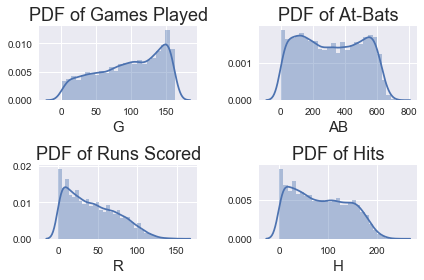

In [18]:
plt.subplot(2,2,1)
sns.distplot(df.G)
plt.title("PDF of Games Played")

plt.subplot(2,2,2)
sns.distplot(df.AB)
plt.title("PDF of At-Bats")

plt.subplot(2,2,3)
sns.distplot(df.R)
plt.title("PDF of Runs Scored")

plt.subplot(2,2,4)
sns.distplot(df.H)
plt.title("PDF of Hits")

plt.tight_layout()
plt.show()

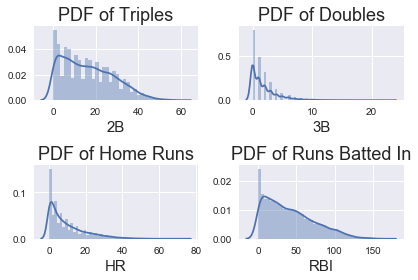

In [19]:
plt.subplot(2,2,1)
sns.distplot(df['2B'])
plt.title("PDF of Triples")

plt.subplot(2,2,2)
sns.distplot(df['3B'])
plt.title("PDF of Doubles")

plt.subplot(2,2,3)
sns.distplot(df.HR)
plt.title("PDF of Home Runs")

plt.subplot(2,2,4)
sns.distplot(df.RBI)
plt.title("PDF of Runs Batted In")

plt.tight_layout()
plt.show()

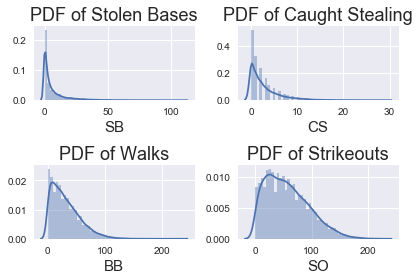

In [20]:
plt.subplot(2,2,1)
sns.distplot(df.SB)
plt.title("PDF of Stolen Bases")

plt.subplot(2,2,2)
sns.distplot(df.CS)
plt.title("PDF of Caught Stealing")

plt.subplot(2,2,3)
sns.distplot(df.BB)
plt.title("PDF of Walks")

plt.subplot(2,2,4)
sns.distplot(df.SO)
plt.title("PDF of Strikeouts")

plt.tight_layout()
plt.show()

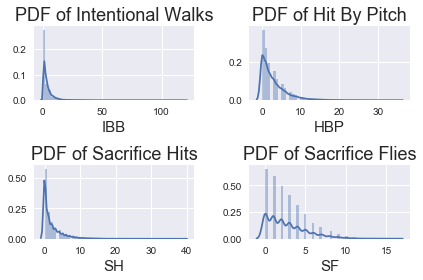

In [21]:
plt.subplot(2,2,1)
sns.distplot(df.IBB)
plt.title("PDF of Intentional Walks")

plt.subplot(2,2,2)
sns.distplot(df.HBP)
plt.title("PDF of Hit By Pitch")

plt.subplot(2,2,3)
sns.distplot(df.SH)
plt.title("PDF of Sacrifice Hits")

plt.subplot(2,2,4)
sns.distplot(df.SF)
plt.title("PDF of Sacrifice Flies")

plt.tight_layout()
plt.show()

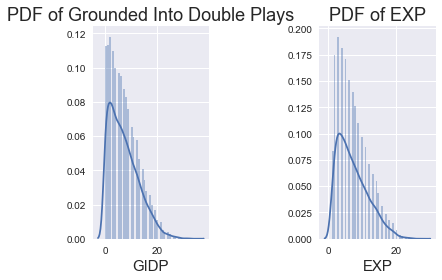

In [22]:
plt.subplot(1,2,1)
sns.distplot(df.GIDP)
plt.title("PDF of Grounded Into Double Plays")

plt.subplot(1,2,2)
sns.distplot(df.EXP)
plt.title("PDF of EXP")

plt.tight_layout()
plt.show()

Now let's look at the distribution of the target variable. We will need to adjust salary for inflation, but let's first look at the distibution of unadjusted salary, or salary in nominal terms.

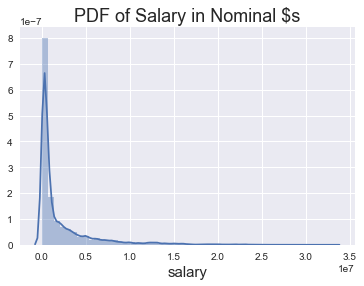

In [23]:

sns.distplot(df.salary)
plt.title("PDF of Salary in Nominal $s")

plt.show()

Plot unadjusted salary over time for the years 1985 - 2016.  Unadjusted salary is salary that is not adjusted for inflation, or is in nominal dollars.

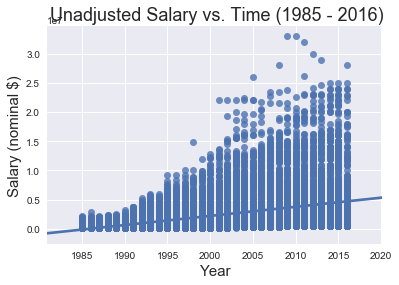

In [24]:
sns.regplot(x='yearID',
            y='salary',
           data=df)
plt.title(' Unadjusted Salary vs. Time (1985 - 2016)')
plt.xlabel('Year')
plt.ylabel('Salary (nominal $)')
plt.show()

Need to adjust salary for inflation.  For ease of interpretation, let's use 2016 dollars.  Use the CPI to calculate this.

In [25]:
cpi = pd.read_csv('CPI.csv')
cpi.head()

,yearID,CPI
0,1985,107.6
1,1986,109.6
2,1987,113.6
3,1988,118.3
4,1989,124.0


Merge the salary data and cpi data by year.  Use the CPI value to adjust salary to 2016 dollars.

In [26]:
salary_adj = pd.merge(df, cpi, how='left', on='yearID')
salary_adj.describe()

,yearID,stint,G,AB,R,H,2B,3B,HR,RBI,...,HBP,SH,SF,GIDP,EXP,allStar,salary,min_salary,is_min,CPI
count,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,...,12395.000000,12395.000000,12395.00000,12395.000000,12395.000000,12395.000000,1.239500e+04,12395.000000,1.239500e+04,12395.000000
mean,2000.337959,1.006374,96.494474,314.486244,43.352723,84.273175,16.336749,1.815571,9.658733,41.398951,...,2.913514,1.937797,2.71077,7.214683,7.234207,0.101170,2.267902e+06,234123.854296,2.033779e+06,175.194199
std,8.806370,0.085450,45.923603,189.707727,31.416071,56.022586,11.857439,2.311864,10.052494,31.807532,...,3.481518,2.919265,2.52130,5.628885,4.548992,0.301566,3.696890e+06,151236.981636,3.644429e+06,39.323835
min,1985.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,6.000000e+04,60000.000000,0.000000e+00,107.600000
25%,1993.000000,1.000000,59.000000,144.000000,16.000000,34.000000,6.000000,0.000000,2.000000,15.000000,...,0.000000,0.000000,1.00000,3.000000,4.000000,0.000000,3.000000e+05,109000.000000,3.837500e+04,144.500000
50%,2000.000000,1.000000,103.000000,310.000000,38.000000,79.000000,15.000000,1.000000,6.000000,35.000000,...,2.000000,1.000000,2.00000,6.000000,6.000000,0.000000,6.250000e+05,200000.000000,4.400000e+05,172.200000
75%,2008.000000,1.000000,138.000000,484.500000,67.000000,131.000000,25.000000,3.000000,14.000000,62.000000,...,4.000000,3.000000,4.00000,11.000000,10.000000,0.000000,2.550000e+06,390000.000000,2.316000e+06,214.500000
max,2016.000000,3.000000,163.000000,716.000000,152.000000,240.000000,59.000000,23.000000,73.000000,165.000000,...,35.000000,39.000000,16.00000,35.000000,28.000000,1.000000,3.300000e+07,507500.000000,3.260000e+07,240.000000


In [27]:
salary_adj['salary2016'] = (240/salary_adj.CPI)*salary_adj.salary
salary_adj['min_salary2016'] =(240/salary_adj.CPI)*salary_adj.min_salary
salary_adj.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,GIDP,_merge,EXP,allStar,salary,min_salary,is_min,CPI,salary2016,min_salary2016
0,rosepe01,1985,1,CIN,NL,119,405,60,107,12,...,10.0,left_only,24,1.0,358858,60000,298858,107.6,8.004268e+05,133828.996283
1,rosepe01,1986,1,CIN,NL,72,237,15,52,8,...,2.0,left_only,25,0.0,1000000,60000,940000,109.6,2.189781e+06,131386.861314
2,staubru01,1985,1,NYN,NL,54,45,2,12,3,...,1.0,left_only,24,0.0,300000,60000,240000,107.6,6.691450e+05,133828.996283
3,perezto01,1985,1,CIN,NL,72,183,25,60,8,...,2.0,left_only,22,0.0,225000,60000,165000,107.6,5.018587e+05,133828.996283
4,perezto01,1986,1,CIN,NL,77,200,14,51,12,...,6.0,left_only,23,0.0,275000,60000,215000,109.6,6.021898e+05,131386.861314


No we can look at the distribution and scatter plot over time for salary in constant 2016 dollars.

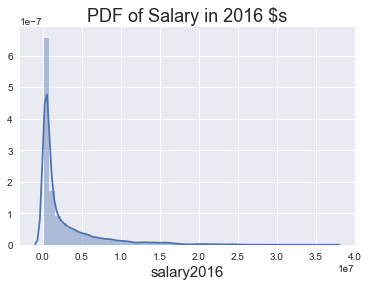

In [28]:
sns.distplot(salary_adj.salary2016)
plt.title("PDF of Salary in 2016 $s")

plt.show()

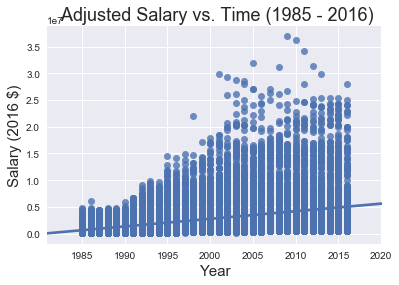

In [29]:
sns.regplot(x='yearID',
            y='salary2016',
           data=salary_adj)
plt.title(' Adjusted Salary vs. Time (1985 - 2016)')
plt.xlabel('Year')
plt.ylabel('Salary (2016 $)')
plt.show()

Considering the salary data is heavily skewed to the right, we will want to use the log of salary instead.  Let's look at that ditribution.

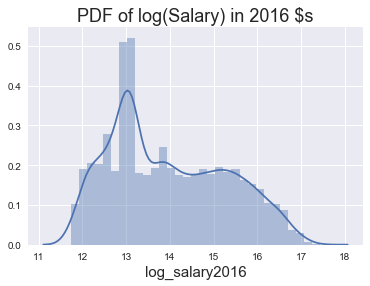

In [30]:
salary_adj['log_salary2016'] = np.log(salary_adj['salary2016'])
sns.distplot(salary_adj.log_salary2016)
plt.title("PDF of log(Salary) in 2016 $s")

plt.show()

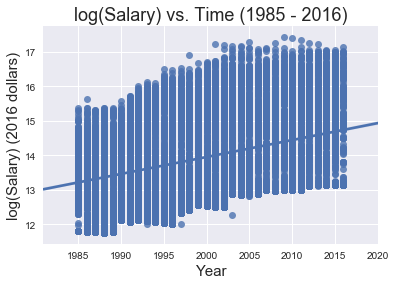

In [31]:
sns.regplot(x='yearID',
            y='log_salary2016',
           data=salary_adj)
plt.title('log(Salary) vs. Time (1985 - 2016)')
plt.xlabel('Year')
plt.ylabel('log(Salary) (2016 dollars)')
plt.show()

Let's look at a pairplot with some of the more important features.


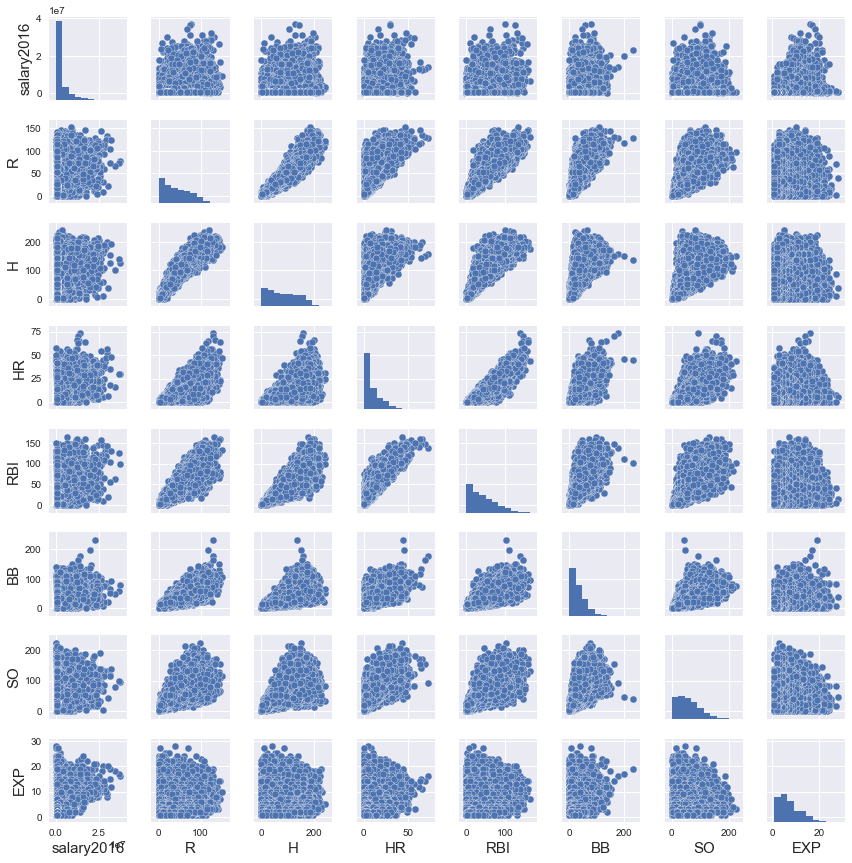

In [32]:
cols = ['salary2016', 'R', 'H', 'HR', 'RBI', 'BB', 'SO', 'EXP']
sns.pairplot(salary_adj[cols], size = 1.5)

plt.show()

In [34]:
corr = salary_adj[cols].corr()
corr.style.background_gradient().set_precision(2)

,salary2016,R,H,HR,RBI,BB,SO,EXP
salary2016,1,0.4,0.38,0.44,0.44,0.42,0.32,0.43
R,0.4,1,0.95,0.78,0.89,0.84,0.78,0.077
H,0.38,0.95,1,0.71,0.89,0.78,0.76,0.085
HR,0.44,0.78,0.71,1,0.9,0.72,0.75,0.11
RBI,0.44,0.89,0.89,0.9,1,0.79,0.78,0.12
BB,0.42,0.84,0.78,0.72,0.79,1,0.72,0.15
SO,0.32,0.78,0.76,0.75,0.78,0.72,1,0.0064
EXP,0.43,0.077,0.085,0.11,0.12,0.15,0.0064,1


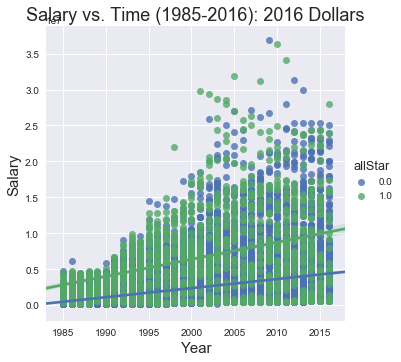

In [35]:
sns.lmplot(x='yearID',
            y='salary2016',
            hue = 'allStar',
            data=salary_adj)
plt.title('Salary vs. Time (1985-2016): 2016 Dollars')
plt.ylabel('Salary')
plt.xlabel('Year')
plt.show()

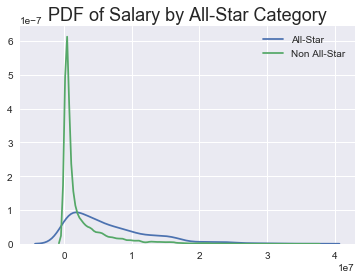

In [36]:
all_star_on = salary_adj[salary_adj.allStar == 1]
all_star_off = salary_adj[salary_adj.allStar == 0]

sns.kdeplot(all_star_on.salary2016, label="All-Star")
sns.kdeplot(all_star_off.salary2016, label="Non All-Star")
plt.title("PDF of Salary by All-Star Category")
plt.show()

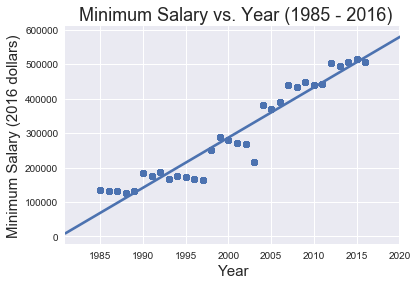

In [37]:
sns.regplot(x='yearID',
            y='min_salary2016',
           data=salary_adj)
plt.title(' Minimum Salary vs. Year (1985 - 2016)')
plt.xlabel('Year')
plt.ylabel('Minimum Salary (2016 dollars)')
plt.show()

In [38]:
top_salary = salary_adj.nlargest(20, 'salary2016')
top_paid = top_salary.playerID.unique()
top_paid



array(['rodrial01', 'ramirma02', 'cabremi01', 'wellsve01', 'giambja01',
       'bondsba01'], dtype=object)

In [39]:
top_paid_players = salary_adj[salary_adj.playerID.isin(['rodrial01', 'ramirma02', 'cabremi01', 'wellsve01', 'giambja01',
       'bondsba01'])]
top_paid_players.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,_merge,EXP,allStar,salary,min_salary,is_min,CPI,salary2016,min_salary2016,log_salary2016
2341,bondsba01,1986,1,PIT,NL,113,413,72,92,26,...,left_only,1,0.0,60000,60000,0,109.6,1.313869e+05,131386.861314,11.785901
2342,bondsba01,1987,1,PIT,NL,150,551,99,144,34,...,left_only,2,0.0,100000,62500,37500,113.6,2.112676e+05,132042.253521,12.260881
2343,bondsba01,1988,1,PIT,NL,144,538,97,152,30,...,left_only,3,0.0,220000,62500,157500,118.3,4.463229e+05,126796.280642,13.008798
2344,bondsba01,1989,1,PIT,NL,159,580,96,144,34,...,left_only,4,0.0,360000,68000,292000,124.0,6.967742e+05,131612.903226,13.454217
2345,bondsba01,1990,1,PIT,NL,151,519,104,156,32,...,left_only,5,1.0,850000,100000,750000,130.7,1.560826e+06,183626.625861,14.260726


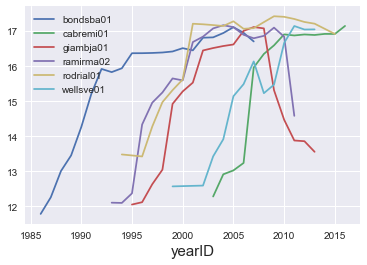

In [40]:
top_paid_players.set_index('yearID', inplace=True)
top_paid_players.groupby('playerID')['log_salary2016'].plot(legend=True)
plt.show()

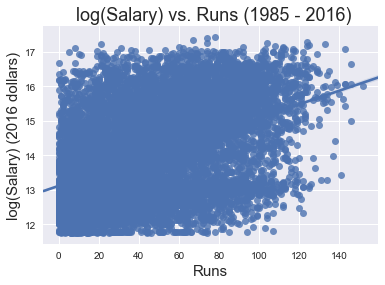

In [41]:
sns.regplot(x='R',
            y='log_salary2016',
           data=salary_adj)
plt.title(' log(Salary) vs. Runs (1985 - 2016)')
plt.xlabel('Runs')
plt.ylabel('log(Salary) (2016 dollars)')
plt.show()

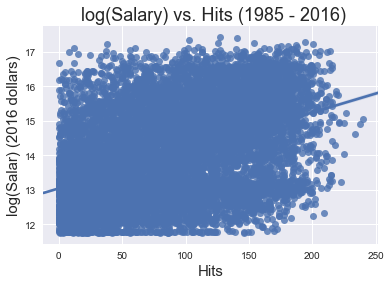

In [42]:
sns.regplot(x='H',
            y='log_salary2016',
           data=salary_adj)
plt.title(' log(Salary) vs. Hits (1985 - 2016)')
plt.xlabel('Hits')
plt.ylabel('log(Salar) (2016 dollars)')
plt.show()

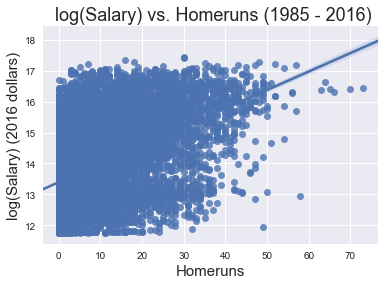

In [43]:
sns.regplot(x='HR',
            y='log_salary2016',
           data=salary_adj)
plt.title(' log(Salary) vs. Homeruns (1985 - 2016)')
plt.xlabel('Homeruns')
plt.ylabel('log(Salary) (2016 dollars)')
plt.show()

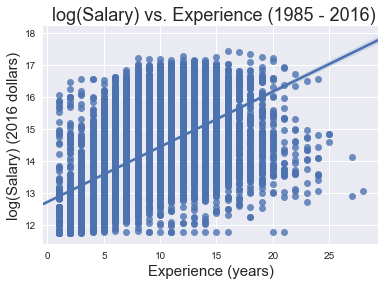

In [44]:
sns.regplot(x='EXP',
            y='log_salary2016',
           data=salary_adj)
plt.title(' log(Salary) vs. Experience (1985 - 2016)')
plt.xlabel('Experience (years)')
plt.ylabel('log(Salary) (2016 dollars)')
plt.show()

## IV. Feature Engineering

Create a batting average feature, which is simply the number hits a player has divided by the number of at-bats.  Al

In [45]:
salary_adj['AVG'] = salary_adj.H / salary_adj.AB *1000
salary_adj['EXP_SQ']=np.square(salary_adj['EXP'])

# salary_adj.sort_values(by=['playerID', 'yearID'])

salary_adj.describe()


,yearID,stint,G,AB,R,H,2B,3B,HR,RBI,...,allStar,salary,min_salary,is_min,CPI,salary2016,min_salary2016,log_salary2016,AVG,EXP_SQ
count,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,...,12395.000000,1.239500e+04,12395.000000,1.239500e+04,12395.000000,1.239500e+04,12395.000000,12395.000000,12395.000000,12395.000000
mean,2000.337959,1.006374,96.494474,314.486244,43.352723,84.273175,16.336749,1.815571,9.658733,41.398951,...,0.101170,2.267902e+06,234123.854296,2.033779e+06,175.194199,2.827202e+06,291864.766089,13.969378,251.966263,73.025413
std,8.806370,0.085450,45.923603,189.707727,31.416071,56.022586,11.857439,2.311864,10.052494,31.807532,...,0.301566,3.696890e+06,151236.981636,3.644429e+06,39.323835,4.194567e+06,134201.742861,1.331716,55.353033,86.533897
min,1985.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,6.000000e+04,60000.000000,0.000000e+00,107.600000,1.267963e+05,126796.280642,11.750337,0.000000,1.000000
25%,1993.000000,1.000000,59.000000,144.000000,16.000000,34.000000,6.000000,0.000000,2.000000,15.000000,...,0.000000,3.000000e+05,109000.000000,3.837500e+04,144.500000,4.104167e+05,171653.543307,12.924928,230.215827,16.000000
50%,2000.000000,1.000000,103.000000,310.000000,38.000000,79.000000,15.000000,1.000000,6.000000,35.000000,...,0.000000,6.250000e+05,200000.000000,4.400000e+05,172.200000,9.408411e+05,266814.897165,13.754529,258.196721,36.000000
75%,2008.000000,1.000000,138.000000,484.500000,67.000000,131.000000,25.000000,3.000000,14.000000,62.000000,...,0.000000,2.550000e+06,390000.000000,2.316000e+06,214.500000,3.521443e+06,439942.112880,15.074381,283.161219,100.000000
max,2016.000000,3.000000,163.000000,716.000000,152.000000,240.000000,59.000000,23.000000,73.000000,165.000000,...,1.000000,3.300000e+07,507500.000000,3.260000e+07,240.000000,3.692308e+07,513924.050633,17.424347,1000.000000,784.000000


Creating lagged values of the target variable and lagged values of the features.  This is based on the idea that salary is based off of past performance.

In [46]:
# lagged values of salary
salary_adj['sal_t_1'] = salary_adj.groupby(['playerID'])['salary2016'].shift(1)
salary_adj['sal_t_2'] = salary_adj.groupby(['playerID'])['salary2016'].shift(2)
salary_adj['sal_t_3'] = salary_adj.groupby(['playerID'])['salary2016'].shift(3)

# first difference of salary lagged one period
salary_adj['sal_diff'] = salary_adj.salary2016 - salary_adj.sal_t_1
salary_adj['sal_diff_t_1'] = salary_adj.groupby(['playerID'])['sal_diff'].shift(1)

# lagged values of the features
salary_adj['G_t_1'] = salary_adj.groupby(['playerID'])['G'].shift(1)
salary_adj['G_t_2'] = salary_adj.groupby(['playerID'])['G'].shift(2)

salary_adj['AB_t_1'] = salary_adj.groupby(['playerID'])['AB'].shift(1)
salary_adj['AB_t_2'] = salary_adj.groupby(['playerID'])['AB'].shift(2)

salary_adj['R_t_1'] = salary_adj.groupby(['playerID'])['R'].shift(1)
salary_adj['R_t_2'] = salary_adj.groupby(['playerID'])['R'].shift(2)

salary_adj['H_t_1'] = salary_adj.groupby(['playerID'])['H'].shift(1)
salary_adj['H_t_2'] = salary_adj.groupby(['playerID'])['H'].shift(2)

salary_adj['2B_t_1'] = salary_adj.groupby(['playerID'])['2B'].shift(1)
salary_adj['2B_t_2'] = salary_adj.groupby(['playerID'])['2B'].shift(2)

salary_adj['3B_t_1'] = salary_adj.groupby(['playerID'])['3B'].shift(1)
salary_adj['3B_t_2'] = salary_adj.groupby(['playerID'])['3B'].shift(2)

salary_adj['HR_t_1'] = salary_adj.groupby(['playerID'])['HR'].shift(1)
salary_adj['HR_t_2'] = salary_adj.groupby(['playerID'])['HR'].shift(2)

salary_adj['RBI_t_1'] = salary_adj.groupby(['playerID'])['RBI'].shift(1)
salary_adj['RBI_t_2'] = salary_adj.groupby(['playerID'])['RBI'].shift(2)

salary_adj['AVG_t_1'] = salary_adj.groupby(['playerID'])['AVG'].shift(1)
salary_adj['AVG_t_2'] = salary_adj.groupby(['playerID'])['AVG'].shift(2)

salary_adj['SB_t_1'] = salary_adj.groupby(['playerID'])['SB'].shift(1)
salary_adj['SB_t_2'] = salary_adj.groupby(['playerID'])['SB'].shift(2)

salary_adj['CS_t_1'] = salary_adj.groupby(['playerID'])['CS'].shift(1)
salary_adj['CS_t_2'] = salary_adj.groupby(['playerID'])['CS'].shift(2)

salary_adj['BB_t_1'] = salary_adj.groupby(['playerID'])['BB'].shift(1)
salary_adj['BB_t_2'] = salary_adj.groupby(['playerID'])['BB'].shift(2)

salary_adj['SO_t_1'] = salary_adj.groupby(['playerID'])['SO'].shift(1)
salary_adj['SO_t_2'] = salary_adj.groupby(['playerID'])['SO'].shift(2)

salary_adj['IBB_t_1'] = salary_adj.groupby(['playerID'])['IBB'].shift(1)
salary_adj['IBB_t_2'] = salary_adj.groupby(['playerID'])['IBB'].shift(2)

salary_adj['HBP_t_1'] = salary_adj.groupby(['playerID'])['HBP'].shift(1)
salary_adj['HBP_t_2'] = salary_adj.groupby(['playerID'])['HBP'].shift(2)

salary_adj['SH_t_1'] = salary_adj.groupby(['playerID'])['SH'].shift(1)
salary_adj['SH_t_2'] = salary_adj.groupby(['playerID'])['SH'].shift(2)

salary_adj['SF_t_1'] = salary_adj.groupby(['playerID'])['SF'].shift(1)
salary_adj['SF_t_2'] = salary_adj.groupby(['playerID'])['SF'].shift(2)

salary_adj['GIDP_t_1'] = salary_adj.groupby(['playerID'])['GIDP'].shift(1)
salary_adj['GIDP_t_2'] = salary_adj.groupby(['playerID'])['GIDP'].shift(2)

salary_adj['allStar_t_1'] = salary_adj.groupby(['playerID'])['allStar'].shift(1)
salary_adj['allStar_t_2'] = salary_adj.groupby(['playerID'])['allStar'].shift(2)
#salary_adj.sort_values(by=['playerID', 'yearID'])

On Base Percentage (aka OBP, On Base Average, OBA) is a measure of how often a batter reaches base. It is approximately equal to Times on Base/Plate appearances.

The full formula is OBP = (Hits + Walks + Hit by Pitch) / (At Bats + Walks + Hit by Pitch + Sacrifice Flies). Batters are not credited with reaching base on an error or fielder's choice, and they are not charged with an opportunity if they make a sacrifice bunt.

In [47]:
salary_adj['OBP'] = 1000*(salary_adj.H + salary_adj.BB + salary_adj.HBP)/(salary_adj.AB + salary_adj.BB + salary_adj.HBP
                                                                    + salary_adj.SF)

# Create lagged value of OBP
salary_adj['OBP_t_1'] = salary_adj.groupby(['playerID'])['OBP'].shift(1)
salary_adj['OBP_t_2'] = salary_adj.groupby(['playerID'])['OBP'].shift(2)

In [48]:
salary_adj['exp_runs'] = salary_adj.EXP*salary_adj.R
salary_adj['exp_AVG'] = salary_adj.EXP*salary_adj.AVG
salary_adj['exp_HR'] = salary_adj.EXP*salary_adj.HR
salary_adj['exp_OBP'] = salary_adj.EXP*salary_adj.OBP
salary_adj['exp_H'] = salary_adj.EXP*salary_adj.H
salary_adj['exp_RBI'] = salary_adj.EXP*salary_adj.RBI
salary_adj['exp_SO'] = salary_adj.EXP*salary_adj.SO


salary_adj['constant'] = 1

In [49]:
salary_adj.describe()

,yearID,stint,G,AB,R,H,2B,3B,HR,RBI,...,OBP_t_1,OBP_t_2,exp_runs,exp_AVG,exp_HR,exp_OBP,exp_H,exp_RBI,exp_SO,constant
count,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,...,10156.000000,8394.000000,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,12395.000000,12395.0
mean,2000.337959,1.006374,96.494474,314.486244,43.352723,84.273175,16.336749,1.815571,9.658733,41.398951,...,327.556356,331.426249,324.608794,1839.382268,74.854861,2345.748569,631.326825,317.308834,413.028560,1.0
std,8.806370,0.085450,45.923603,189.707727,31.416071,56.022586,11.857439,2.311864,10.052494,31.807532,...,54.039849,51.978822,328.803849,1238.915779,102.227814,1589.863234,599.966682,341.897882,383.383984,0.0
min,1985.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,1993.000000,1.000000,59.000000,144.000000,16.000000,34.000000,6.000000,0.000000,2.000000,15.000000,...,301.636495,305.775454,78.000000,855.958861,9.000000,1084.489922,165.000000,70.000000,128.000000,1.0
50%,2000.000000,1.000000,103.000000,310.000000,38.000000,79.000000,15.000000,1.000000,6.000000,35.000000,...,329.896907,333.333333,216.000000,1590.909091,36.000000,2013.422819,450.000000,204.000000,300.000000,1.0
75%,2008.000000,1.000000,138.000000,484.500000,67.000000,131.000000,25.000000,3.000000,14.000000,62.000000,...,358.083469,360.795455,468.000000,2578.341613,100.000000,3278.724793,925.000000,448.000000,580.000000,1.0
max,2016.000000,3.000000,163.000000,716.000000,152.000000,240.000000,59.000000,23.000000,73.000000,165.000000,...,1000.000000,1000.000000,2451.000000,11250.000000,1168.000000,12500.000000,4275.000000,2540.000000,3045.000000,1.0


## V. Modeling and Results

In [50]:
y = salary_adj.log_salary2016
x_baseline = salary_adj[['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SF', 'SH',
               'GIDP', 'AVG', 'OBP', 'constant']]

x_ols_exp = salary_adj[['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'SB', 'CS', 'SO', 'IBB', 'HBP', 'SF', 'SH',
               'GIDP', 'AVG', 'OBP', 'EXP', 'EXP_SQ', 'allStar', 'constant']]



x_lag1 = salary_adj[['sal_t_1', 'G_t_1', 'AB_t_1', 'R_t_1', 
                'H_t_1', '2B_t_1', '3B_t_1', 'HR_t_1',
                'RBI_t_1', 'SB_t_1', 'CS_t_1', 'BB_t_1', 'SO_t_1', 
                'IBB_t_1', 'HBP_t_1', 'SH_t_1', 'SF_t_1',
                'GIDP_t_1', 'AVG_t_1',
                'OBP_t_1', 'EXP', 'EXP_SQ', 'allStar_t_1', 'min_salary2016', 'constant']]

# remove the features that have a feature importance of 30 and below
x = salary_adj[['sal_t_1','sal_t_2', #'sal_t_3',
                'min_salary2016',
                'EXP', 'EXP_SQ',# experience or years in the league
                'R_t_1', 'R_t_2',
                #'H_t_1', 'H_t_2',
                'HR_t_1','HR_t_2',
                #'RBI_t_1', 'RBI_t_2',
                'SO_t_1', 'SO_t_2',
                #'AVG_t_1', 'AVG_t_2',
                #'BB_t_1', 'BB_t_2',
                'OBP_t_1', 'OBP_t_2',
                'allStar_t_1',
                'exp_runs',
                'exp_OBP',
                'exp_H', 'constant']]

Create the training and test splits.

In [51]:
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(x_baseline, y, test_size=.25, random_state=1234)

In [52]:
X_train_ols_exp, X_test_ols_exp, y_train_ols_exp, y_test_ols_exp = train_test_split(x_ols_exp,
                                                                                    y,
                                                                                    test_size=.25,
                                                                                    random_state=1)

In [53]:
X_train_lag1, X_test_lag1, y_train_lag1, y_test_lag1 = train_test_split(x_lag1, y, test_size=.25, random_state=1)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=66)


In [55]:
X_train.head()

,sal_t_1,sal_t_2,min_salary2016,EXP,EXP_SQ,R_t_1,R_t_2,HR_t_1,HR_t_2,SO_t_1,SO_t_2,OBP_t_1,OBP_t_2,allStar_t_1,exp_runs,exp_OBP,exp_H,constant
9429,2.202381e+06,1.142857e+06,439942.112880,7,49,53.0,62.0,16.0,18.0,85.0,107.0,350.543478,332.589286,0.0,588,2482.195846,1092,1
7618,8.847926e+06,1.778719e+07,389285.714286,10,100,38.0,32.0,8.0,9.0,35.0,22.0,358.600583,351.351351,0.0,820,3498.452012,1770,1
4436,2.392523e+06,1.682600e+06,250306.748466,9,81,59.0,85.0,2.0,5.0,64.0,98.0,359.139785,384.012539,0.0,918,3628.005658,1719,1
6267,2.542056e+05,1.912046e+05,250306.748466,5,25,9.0,12.0,1.0,1.0,28.0,22.0,261.437908,267.515924,0.0,0,1111.111111,10,1
10454,1.596567e+07,1.567944e+07,506970.849176,11,121,62.0,49.0,20.0,14.0,52.0,72.0,401.785714,321.518987,0.0,704,4060.546875,1397,1


In [56]:
X_base_train.describe()

,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SF,SH,GIDP,AVG,OBP,constant
count,9296.000000,9296.000000,9296.000000,9296.000000,9296.000000,9296.000000,9296.000000,9296.000000,9296.000000,9296.000000,9296.000000,9296.000000,9296.000000,9296.000000,9296.000000,9296.000000,9296.000000,9296.000000,9296.000000,9296.0
mean,96.483326,314.278722,43.343804,84.173515,16.314544,1.832401,9.663511,41.385757,6.312070,2.680615,31.270116,56.799914,2.661252,2.906411,2.711166,1.977194,7.202560,251.860252,319.370145,1.0
std,45.927371,189.692655,31.368238,55.962441,11.800540,2.330906,10.032296,31.750721,9.850249,3.317756,25.043825,37.841136,4.216368,3.485628,2.536733,2.980791,5.606743,56.292784,62.790067,0.0
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,59.000000,144.750000,16.000000,34.000000,6.000000,0.000000,2.000000,15.000000,0.000000,0.000000,11.000000,26.000000,0.000000,0.000000,1.000000,0.000000,3.000000,230.031949,293.185190,1.0
50%,103.000000,309.000000,38.000000,79.000000,15.000000,1.000000,6.000000,35.000000,2.000000,2.000000,26.000000,51.000000,1.000000,2.000000,2.000000,1.000000,6.000000,257.950530,324.225416,1.0
75%,138.000000,484.000000,67.000000,131.000000,25.000000,3.000000,14.000000,62.000000,8.000000,4.000000,45.000000,82.000000,3.000000,4.000000,4.000000,3.000000,11.000000,283.185841,353.922576,1.0
max,163.000000,716.000000,152.000000,240.000000,59.000000,23.000000,73.000000,165.000000,110.000000,28.000000,232.000000,211.000000,120.000000,35.000000,16.000000,39.000000,32.000000,1000.000000,1000.000000,1.0


### Linear Regression Models

In [57]:

#X_base_train['const'] = 1
#X_base_test['const'] = 1
#X_train_ols_exp['const'] = 1
#X_test_ols_exp['const'] = 1
#X_train_lag1['const'] = 1
#X_test_lag1['const'] = 1
#X_train['const'] = 1
#X_test['const'] = 1

In [58]:
from sklearn.linear_model import LinearRegression
model_linear = LinearRegression()
model_linear.fit(X_base_train, y_base_train)
model_linear.score(X_base_train, y_base_train)

0.33020811657828264

In [59]:
reg1 = sm.OLS(y_base_train, X_base_train, missing='drop')
results = reg1.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         log_salary2016   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     240.7
Date:                Tue, 26 Jun 2018   Prob (F-statistic):               0.00
Time:                        19:12:46   Log-Likelihood:                -14010.
No. Observations:                9296   AIC:                         2.806e+04
Df Residuals:                    9276   BIC:                         2.820e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
G             -0.0154      0.001    -17.571      0.0

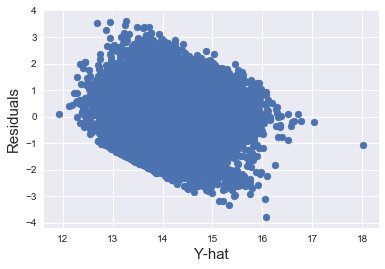

In [60]:
y_pred_base_train = model_linear.predict(X_base_train)
residual_base_train = y_base_train - y_pred_base_train
plt.scatter(y_pred_base_train, residual_base_train)
plt.xlabel('Y-hat')
plt.ylabel('Residuals')
plt.show()

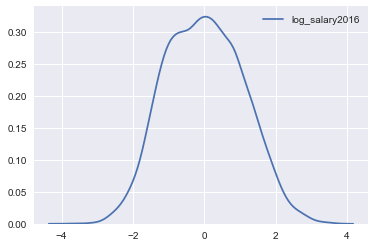

In [61]:
sns.kdeplot(residual_base_train)
plt.show()

In [62]:
from sklearn.metrics import mean_squared_error
from math import sqrt
sqrt(mean_squared_error(y_base_train, y_pred_base_train))

1.0921209512334087

In [63]:
ols_exp = sm.OLS(y_train_ols_exp, X_train_ols_exp, missing='drop')
results_ols_exp = ols_exp.fit()
print(results_ols_exp.summary())

                            OLS Regression Results                            
Dep. Variable:         log_salary2016   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     841.0
Date:                Tue, 26 Jun 2018   Prob (F-statistic):               0.00
Time:                        19:12:54   Log-Likelihood:                -10786.
No. Observations:                9296   AIC:                         2.162e+04
Df Residuals:                    9273   BIC:                         2.178e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
G             -0.0167      0.001    -27.092      0.0

In [64]:
ols_lag1 = sm.OLS(y_train_lag1, X_train_lag1, missing='drop')
results_ols_lag1 = ols_lag1.fit()
print(results_ols_lag1.summary())

                            OLS Regression Results                            
Dep. Variable:         log_salary2016   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     1234.
Date:                Tue, 26 Jun 2018   Prob (F-statistic):               0.00
Time:                        19:12:55   Log-Likelihood:                -6686.8
No. Observations:                7620   AIC:                         1.342e+04
Df Residuals:                    7595   BIC:                         1.360e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
sal_t_1         1.065e-07   2.19e-09     48.

In [65]:
ols_model = sm.OLS(y_train, X_train, missing='drop')
results_ols_model = ols_model.fit()
print(results_ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:         log_salary2016   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     1320.
Date:                Tue, 26 Jun 2018   Prob (F-statistic):               0.00
Time:                        19:12:56   Log-Likelihood:                -5374.2
No. Observations:                6284   AIC:                         1.078e+04
Df Residuals:                    6266   BIC:                         1.091e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
sal_t_1         1.276e-07   4.52e-09     28.

### XGBoost Models

In [66]:
import xgboost as xgb

In [67]:
# First XGBoost model for Batting Salary dataset

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=5, random_state=7)

model_xgb = XGBRegressor(objective='reg:linear',
                         n_estimators=400,
                         max_depth=6,
                         learning_rate = 0.08,
                         colsample_bytree=1,
                         subsample = .9,
                         gamma = 1,
                         min_child_weight=5,
                         nthreads=4,
                         seed=123,
                         eval_metric="rmse")



results = cross_val_score(model_xgb, X_train, y_train, cv=kfold)

print(results)

model_xgb.fit(X_train, y_train)


# make predictions for test data
y_pred = model_xgb.predict(X_test)

print("Score_XGB:", model_xgb.score(X_test, y_test))


[0.90871155 0.90170243 0.89472468 0.90078333 0.89865858]
Score_XGB: 0.9058898142253092


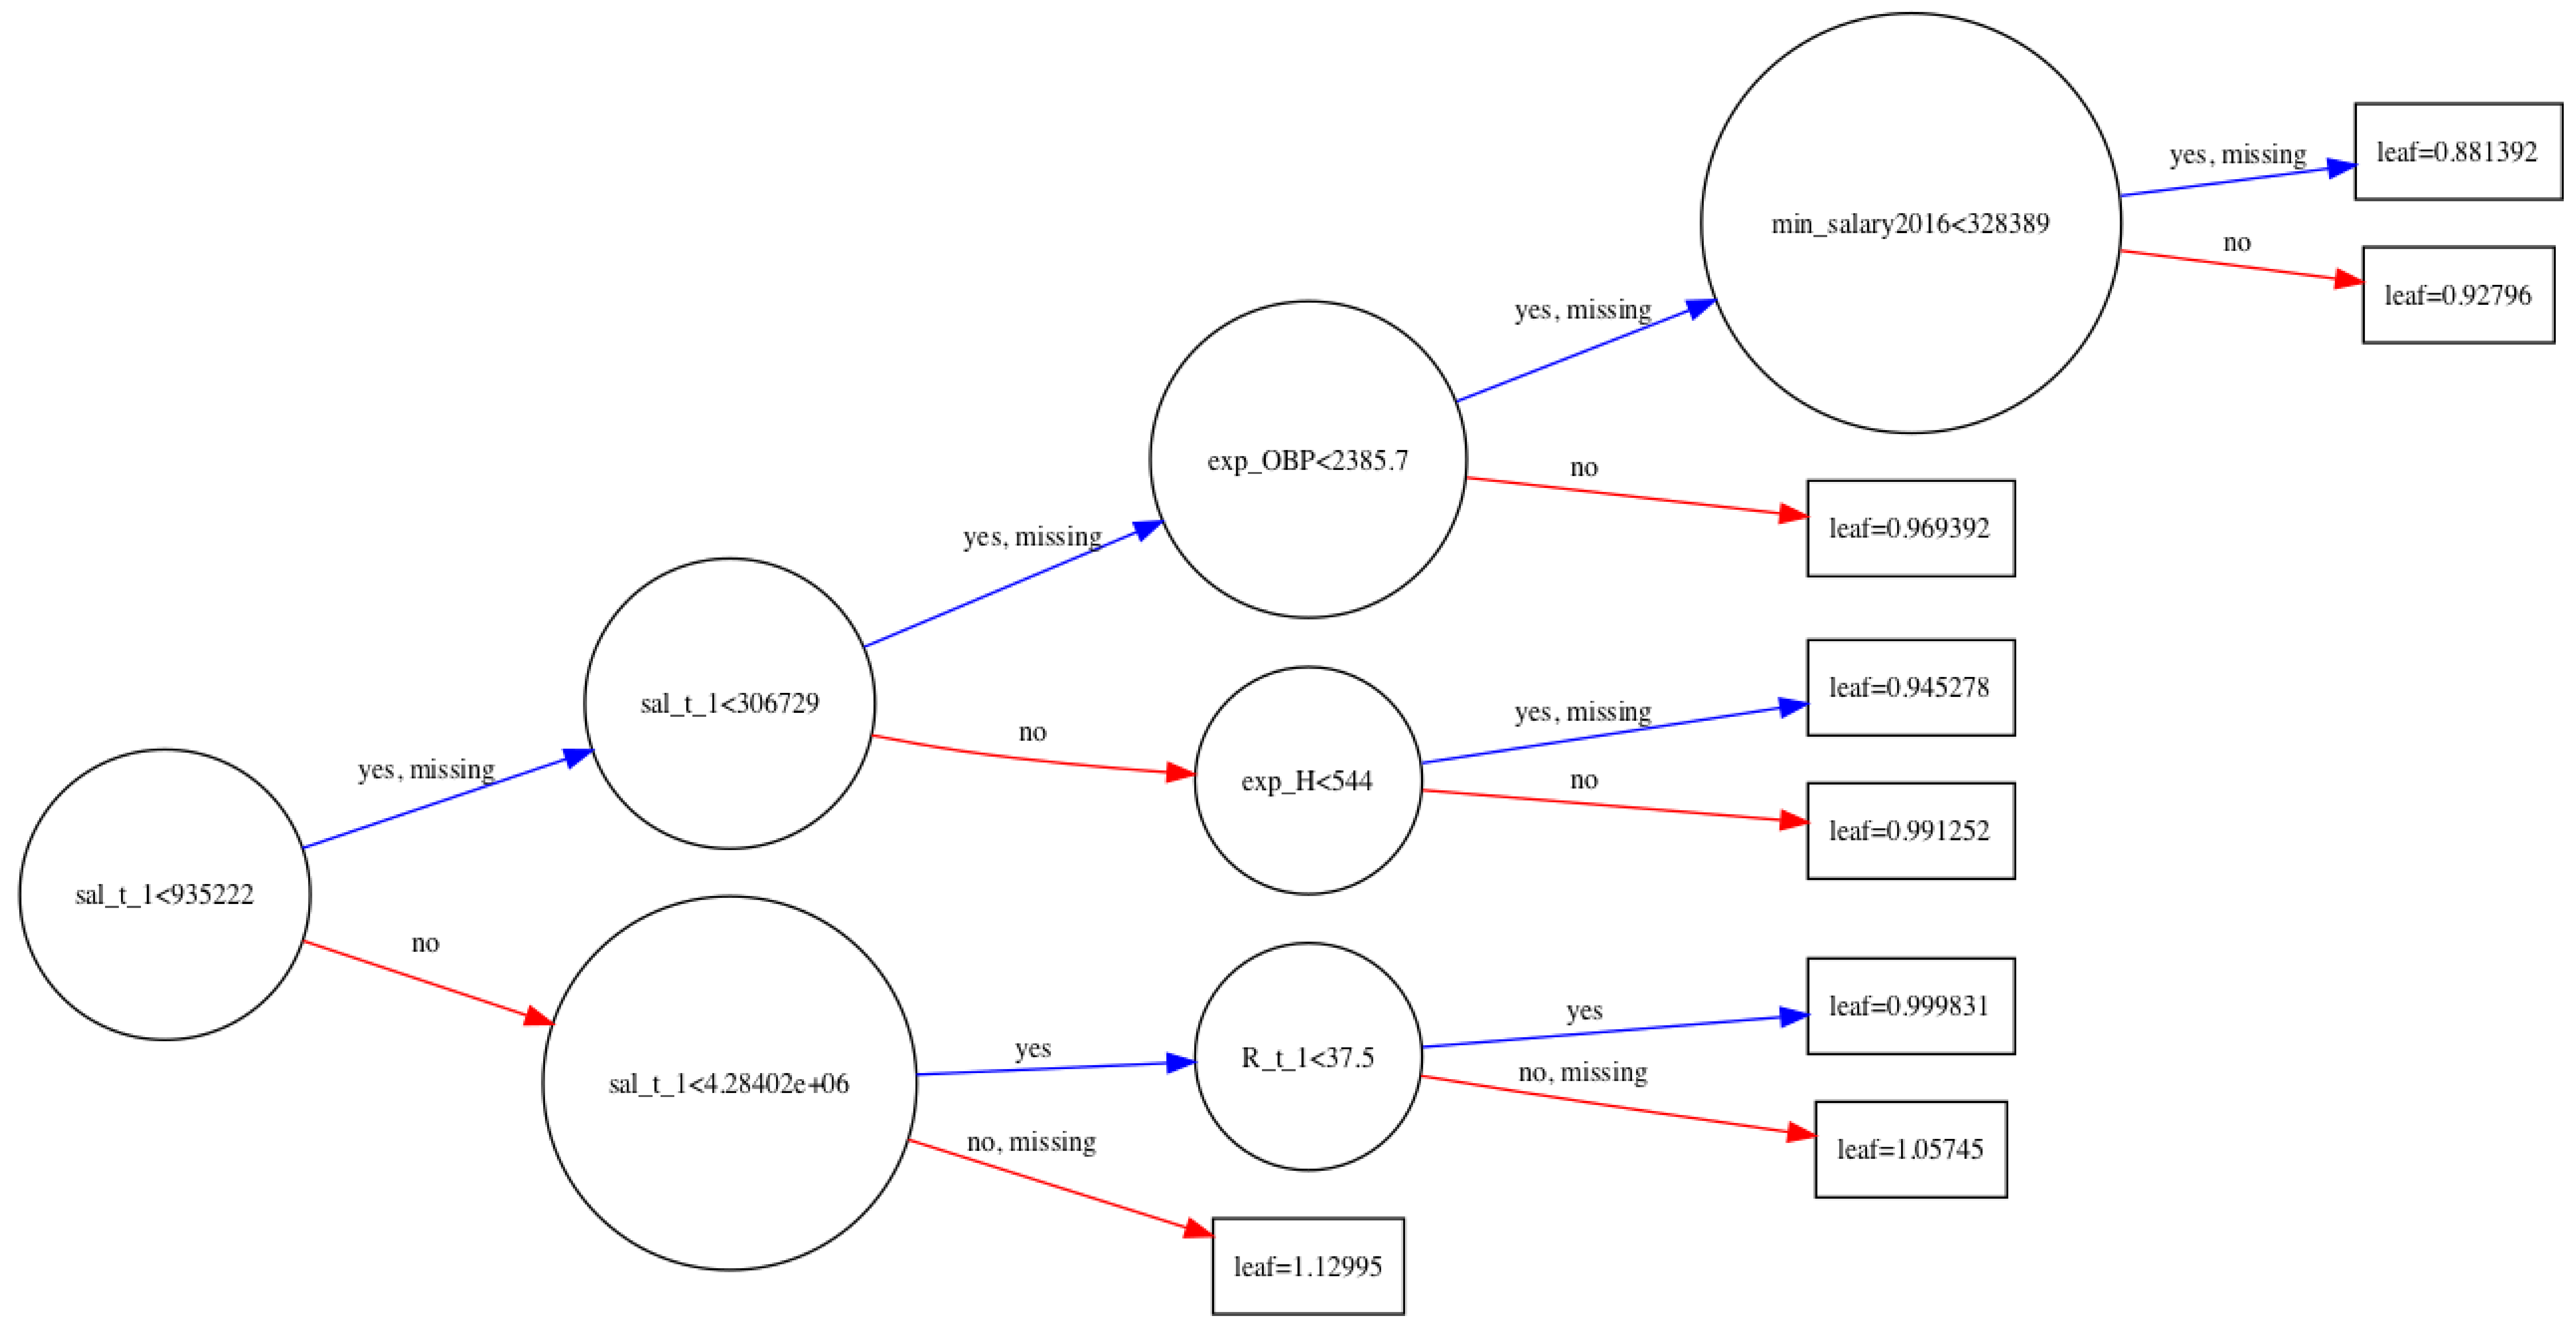

In [68]:
import graphviz
xgb.plot_tree(model_xgb, num_trees=1, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

In [69]:
 import scipy.stats as st

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(100, 500),
    "max_depth": st.randint(4, 6),
    "learning_rate": st.uniform(0.05, 0.1),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgbreg = XGBRegressor(objective='reg:linear', nthreads=-1, seed = 123)  

from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(xgbreg, params, n_jobs=1)  
gs.fit(X_train, y_train)
print("Score_XGB:", gs.score(X_test, y_test))



Score_XGB: 0.9023998299140645


In [70]:
residual = y_test - y_pred

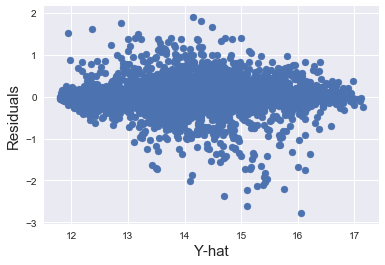

In [71]:
plt.scatter(y_pred, residual)
plt.xlabel('Y-hat')
plt.ylabel('Residuals')
plt.show()

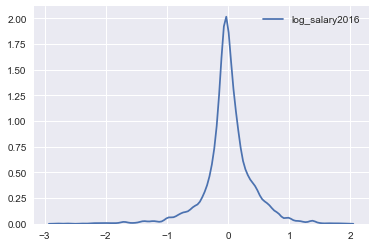

In [72]:
sns.kdeplot(residual)
plt.show()

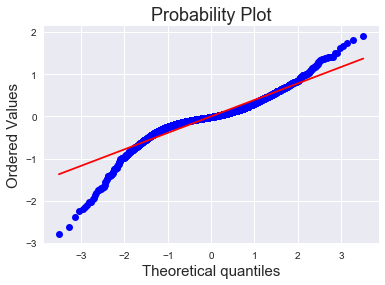

In [73]:
import pylab
import scipy.stats as scipystats
scipystats.probplot(residual, dist="norm", plot=pylab)
pylab.show()

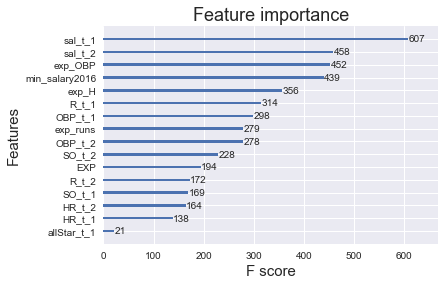

In [74]:
xgb.plot_importance(model_xgb)

Text(0,0.5,'Residuals')

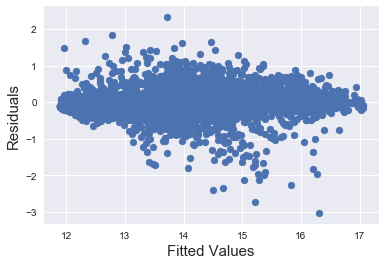

In [75]:
y_pred_gs = gs.predict(X_test)
res_gs = y_test - y_pred_gs
plt.scatter(y_pred_gs, res_gs)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

In [76]:
from sklearn.metrics import mean_squared_error
sqrt(mean_squared_error(y_test, y_pred))

0.4101871821785593

In [77]:
# Second XGBoost model for Batting Salary dataset - only include 1 lag and include everything

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=5, random_state=7)

model_xgb_lag1 = XGBRegressor(objective='reg:linear',
                         n_estimators=500,
                         max_depth=6,
                         learning_rate = 0.08,
                         colsample_bytree=1,
                         subsample = .8,
                         gamma = 1,
                         min_child_weight=5,
                         nthreads=4,
                         seed=123,
                         eval_metric="rmse")



results_lag1 = cross_val_score(model_xgb_lag1, X_train_lag1, y_train_lag1, cv=kfold)

print(results_lag1)

model_xgb_lag1.fit(X_train_lag1, y_train_lag1)


# make predictions for test data
y_pred_lag1 = model_xgb_lag1.predict(X_test_lag1)

print("Score_XGB:", model_xgb_lag1.score(X_test_lag1, y_test_lag1))


[0.89611637 0.8964671  0.89947587 0.88043623 0.88920829]
Score_XGB: 0.8913508066547764


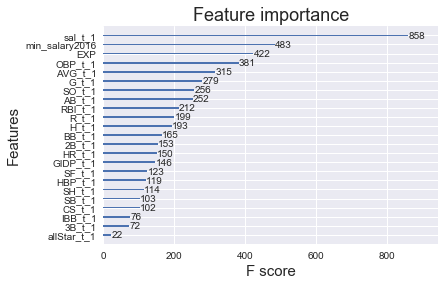

In [78]:
xgb.plot_importance(model_xgb_lag1)